<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/text%20summarization/Seq2Seq_Varianats_Based_Text_Summarization_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# notebook inspired from https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/

In [57]:
# downgrading numpy required else error is thrown when "Object arrays cannot be loaded when allow_pickle=False' when trying to load  " 
!pip install numpy==1.16.2

     |████████████████████████████████| 17.3MB 202kB/s 
ERROR: tensorflow-model-optimization 0.1.3 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.11.0 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.11.0 has requirement attrs~=18.2, but you'll have attrs 19.3.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement cachetools~=3.1.1, but you'll have cachetools 4.0.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement grpcio~=1.24.3, but you'll have grpcio 1.26.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement portpicker~=1.3.1, but you'll have portpicker 1.2.0 which is incompatible.
ERROR: tensorflow-federated 0.11.0 has requirement tensorflow~=2.0.0, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-col

In [1]:
# downloading data and importing modules
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import range, input 

import urllib
urllib.request.urlretrieve(url='https://raw.githubusercontent.com/docketrun/Detecting-Fake-News-with-Scikit-Learn/master/fake_or_real_news.csv')

import os, sys, gc, six;
import zipfile, itertools, functools;
gc.enable()

!ls -GFlash --color

total 30M
4.0K drwxr-xr-x 1 root 4.0K Feb  4 13:36 ./
4.0K drwxr-xr-x 1 root 4.0K Feb  4 11:25 ../
4.0K drwxr-xr-x 1 root 4.0K Jan 31 17:11 .config/
 30M -rw-r--r-- 1 root  30M Feb  4 11:26 fake_or_real_news.csv
4.0K drwxr-xr-x 2 root 4.0K Feb  4 13:37 models/
4.0K drwxr-xr-x 2 root 4.0K Feb  4 13:47 reports/
4.0K drwxr-xr-x 1 root 4.0K Jan 30 17:25 sample_data/
4.0K drwxr-xr-x 2 root 4.0K Feb  4 13:21 very_large_data/


In [2]:
# importing all the modules for model building and data cleaning
%load_ext autoreload
%autoreload 2
%precision 5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,10)})

from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Activation, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import plot_model, get_file 
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.simplefilter("ignore")

TensorFlow 2.x selected.


In [0]:
# data load and preprocessing

In [0]:
MAX_INPUT_SEQ_LENGTH = 500
MAX_TARGET_SEQ_LENGTH = 50
MAX_INPUT_VOCAB_SIZE = 5000
MAX_TARGET_VOCAB_SIZE = 2000
GLOVE_EMBEDDING_SIZE = 100

def fit_text(X, Y, input_seq_max_length=None, target_seq_max_length=None):
  if input_seq_max_length is None:
    input_seq_max_length = MAX_INPUT_SEQ_LENGTH
  if target_seq_max_length is None:
    target_seq_max_length = MAX_TARGET_SEQ_LENGTH 
  input_counter = Counter()
  target_counter = Counter()
  max_input_seq_length = 0
  max_target_seq_length = 0

  for line in X:
    text = [word.lower() for word in line.split(' ')]
    seq_length = text.__len__()
    if seq_length > input_seq_max_length:
      text = text[0:input_seq_max_length]
      seq_length = len(text)
    for word in text:
      input_counter[word]+= 1
    max_input_seq_length = max(max_input_seq_length, seq_length)
  

  for line in Y:
    line2 = 'START ' + line.lower() + ' END'
    text = [word for word in line2.split(' ')]
    seq_length = text.__len__()
    if seq_length > target_seq_max_length:
      text = text[0:target_seq_max_length]
      seq_length = len(text)
    for word in text:
      target_counter[word]+= 1
      max_target_seq_length = max(max_target_seq_length, seq_length)

  input_word2idx = dict()
  for idx, word in enumerate(input_counter.most_common(MAX_INPUT_VOCAB_SIZE)):
    input_word2idx[word[0]] = idx+2
  input_word2idx['PAD'] = 0
  input_word2idx['UNK'] = 1
  input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])

  target_word2idx = dict()
  for idx, word in enumerate(target_counter.most_common(MAX_TARGET_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1
  target_word2idx['UNK'] = 0
  target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

  num_input_tokens = len(input_word2idx)
  num_target_tokens = len(target_word2idx)

  config = {
      'input_word2idx': input_word2idx,
      'input_idx2word': input_idx2word,
      'target_word2idx': target_word2idx,
      'target_idx2word': target_idx2word,
      'num_input_tokens': num_input_tokens,
      'num_target_tokens': num_target_tokens,
      'max_input_seq_length': max_input_seq_length,
      'max_target_seq_length': max_target_seq_length
  }

  return config

In [0]:
# glove loader

In [0]:
def reporthook(block_num, block_size, total_size):
    read_so_far = block_num * block_size
    if total_size > 0:
        percent = read_so_far * 1e2 / total_size
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(total_size)), read_so_far, total_size)
        sys.stderr.write(s)
        if read_so_far >= total_size:  
            sys.stderr.write("\n")
    else:  
        sys.stderr.write("read %d\n" % (read_so_far,))

In [0]:
def download_glove(data_dir_path = None):
  if data_dir_path is None:
    data_dir_path = 'very_large_data'
  glove_model_path = data_dir_path + '/glove.6B.' + str(GLOVE_EMBEDDING_SIZE) + "d.txt"
  if not os.path.exists(glove_model_path):
    glove_zip = data_dir_path + '/glove.6B.zip'

    if not os.path.exists(data_dir_path):
      os.makedirs(data_dir_path)
    if not os.path.exists(glove_zip):
      print("Glove file does not exist, downloading from internet.")
      urllib.request.urlretrieve(url='http://nlp.stanford.edu/data/glove.6B.zip',filename=glove_zip, reporthook=reporthook)
    print('unzipping glove file...')
    zip_ref = zipfile.ZipFile(glove_zip, 'r')
    zip_ref.extractall(data_dir_path)
    zip_ref.close()

In [0]:
def load_glove(data_dir_path = None):
  if data_dir_path is None:
    data_dir_path = 'very_large_data'
  download_glove(data_dir_path=data_dir_path)
  _word2em = {}
  glove_model_path = data_dir_path + '/glove.6B.' + str(GLOVE_EMBEDDING_SIZE) + "d.txt"
  file = open(glove_model_path, mode='rt', encoding='utf8')
  for line in file:
    words = line.strip().split()
    word = words[0]
    embeds = np.array(words[1:],dtype=np.float32)
    _word2em[word] = embeds
  file.close()
  return _word2em

In [0]:
def glove_zero_emb():
  return np.zeros(shape=GLOVE_EMBEDDING_SIZE)

In [0]:
class Glove(object):
  word2em = None
  GLOVE_EMBEDDING_SIZE = GLOVE_EMBEDDING_SIZE
  def __init__(self):
    self.word2em = load_glove()

In [0]:
# text utils

In [0]:
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
def in_white_list(_word):
    for char in _word:
        if char in WHITELIST:
            return True
    return False

In [0]:
# plot utils

In [0]:
# normalized and unnormalized confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not
    return top classes.)
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print()
    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [0]:
# plot model history
def plot_history_2win(history):
    plt.subplot(211)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], color='g', label='Train')
    plt.plot(history.history['val_acc'], color='b', label='Validation')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.title('Loss')
    plt.plot(history.history['loss'], color='g', label='Train')
    plt.plot(history.history['val_loss'], color='b', label='Validation')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def create_history_plot(history, model_name, metrics=None):
    plt.title('Accuracy and Loss (' + model_name + ')')
    if metrics is None:
        metrics = {'acc', 'loss'}
    if 'acc' in metrics:
        plt.plot(history.history['acc'], color='g', label='Train Accuracy')
        plt.plot(history.history['val_acc'], color='b', label='Validation Accuracy')
    if 'loss' in metrics:
        plt.plot(history.history['loss'], color='r', label='Train Loss')
        plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')
    plt.tight_layout()

def plot_history(history, model_name):
    create_history_plot(history, model_name)
    plt.show()

def plot_and_save_history(history, model_name, file_path, metrics=None):
    if metrics is None:
        metrics = {'acc', 'loss'}
    create_history_plot(history, model_name, metrics)
    plt.savefig(file_path)

In [0]:
HIDDEN_UNITS = 100
DEFAULT_BATCH_SIZE = 64
VERBOSE = 1
DEFAULT_EPOCHS = 10

In [0]:
class Seq2SeqGloveSummarizer(object):
  model_name = 'seq2seq-glove'
  def __init__(self, config):
    self.max_input_seq_length = config['max_input_seq_length']
    self.num_target_tokens = config['num_target_tokens']
    self.max_target_seq_length = config['max_target_seq_length']
    self.target_word2idx = config['target_word2idx']
    self.target_idx2word = config['target_idx2word']
    self.version = 0
    if 'version' in config:
      self.version = config["version"]
    self.word2em = dict()
    if "unknown_emb" in config:
      self.unknown_emb = config["unknown_emb"]
    else:
      self.unknown_emb = np.random.rand(1, GLOVE_EMBEDDING_SIZE)
      config['unknown_emb'] = self.unknown_emb
    self.config = config 

    encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
    encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    encoder_states = [encoder_state_h, encoder_state_c]

    decoder_inputs = Input(shape=(None, self.num_target_tokens), name='decoder_inputs')
    decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(units=self.num_target_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    self.model = model

    self.encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

  def load_weights(self, weight_file_path):
    if os.path.exists(weight_file_path):
      self.model.load_weights(weight_file_path)
  
  def transform_input_text(self, texts):
    temp = []
    for line in texts:
      x = []
      for word in line.lower().split(' '):
        wid = 1
        if word in self.input_word2idx:
          wid = self.input_word2idx[word]
        x.append(wid)
        if len(x) >= self.max_input_seq_length:
          print("Max input sequence reached.")
          break
      temp.append(x)
    temp = pad_sequences(temp, maxlen=self.max_input_seq_length)
    print(temp.shape)
    return temp 
  
  def transform_target_encoding(self, texts):
    temp = []
    for line in texts:
      x = []
      line2 = 'START ' + line.lower() + ' END'
      for word in line2.split(' '):
        x.append(word)
        if len(x) >= self.max_target_seq_length:
          break
      temp.append(x)
    temp = np.array(temp)
    print(temp.shape)
    return temp

  def generate_batch(self, x_samples, y_samples, batch_size):
    num_batches = len(x_samples) // batch_size
    while True:
      for batchIdx in range(0, num_batches):
        start = batchIdx * batch_size
        end = (batchIdx + 1) * batch_size
        encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
        decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
        decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
        for lineIdx, target_words in enumerate(y_samples[start:end]):
          for idx, w in enumerate(target_words):
            w2idx = 0  
            if w in self.target_word2idx:
              w2idx = self.target_word2idx[w]
            if w2idx != 0:
              decoder_input_data_batch[lineIdx, idx, w2idx] = 1
              if idx > 0:
                decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
        yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

  @staticmethod
  def get_weight_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-weights.h5'

  @staticmethod
  def get_config_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-config.npy'

  @staticmethod
  def get_architecture_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqSummarizer.model_name + '-architecture.json'

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=None, batch_size=None, model_dir_path=None):
      if epochs is None:
        epochs = DEFAULT_EPOCHS
      if model_dir_path is None:
        model_dir_path = './models'
      if batch_size is None:
        batch_size = DEFAULT_BATCH_SIZE

      self.version += 1
      self.config['version'] = self.version
      config_file_path = Seq2SeqSummarizer.get_config_file_path(model_dir_path)
      weight_file_path = Seq2SeqSummarizer.get_weight_file_path(model_dir_path)
      checkpoint = ModelCheckpoint(weight_file_path)
      np.save(config_file_path, self.config)
      architecture_file_path = Seq2SeqSummarizer.get_architecture_file_path(model_dir_path)
      open(architecture_file_path, 'w').write(self.model.to_json())

      Ytrain = self.transform_target_encoding(Ytrain)
      Ytest = self.transform_target_encoding(Ytest)

      Xtrain = self.transform_input_text(Xtrain)
      Xtest = self.transform_input_text(Xtest)

      train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
      test_gen = self.generate_batch(Xtest, Ytest, batch_size)

      train_num_batches = len(Xtrain) // batch_size
      test_num_batches = len(Xtest) // batch_size

      history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                          epochs=epochs,
                                          verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                          callbacks=[checkpoint])
      self.model.save_weights(weight_file_path)
      return history

  def summarize(self, input_text):
    input_seq = []
    input_wids = []
    for word in input_text.lower().split(' '):
      idx = 1  
      if word in self.input_word2idx:
          idx = self.input_word2idx[word]
      input_wids.append(idx)
    input_seq.append(input_wids)
    input_seq = pad_sequences(input_seq, self.max_input_seq_length)
    states_value = self.encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, self.num_target_tokens))
    target_seq[0, 0, self.target_word2idx['START']] = 1
    target_text = ''
    target_text_len = 0
    terminated = False
    while not terminated:
      output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

      sample_token_idx = np.argmax(output_tokens[0, -1, :])
      sample_word = self.target_idx2word[sample_token_idx]
      target_text_len += 1

      if sample_word != 'START' and sample_word != 'END':
          target_text += ' ' + sample_word

      if sample_word == 'END' or target_text_len >= self.max_target_seq_length:
          terminated = True

      target_seq = np.zeros((1, 1, self.num_target_tokens))
      target_seq[0, 0, sample_token_idx] = 1

      states_value = [h, c]
    return target_text.strip()

In [0]:
class Seq2SeqGloVeSummarizer(object):
  model_name = 'seq2seq-glove'

  def __init__(self, config):
      self.max_input_seq_length = config['max_input_seq_length']
      self.num_target_tokens = config['num_target_tokens']
      self.max_target_seq_length = config['max_target_seq_length']
      self.target_word2idx = config['target_word2idx']
      self.target_idx2word = config['target_idx2word']
      self.version = 0
      if 'version' in config:
          self.version = config['version']

      self.word2em = dict()
      if 'unknown_emb' in config:
          self.unknown_emb = config['unknown_emb']
      else:
          self.unknown_emb = np.random.rand(1, GLOVE_EMBEDDING_SIZE)
          config['unknown_emb'] = self.unknown_emb

      self.config = config

      encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
      encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]

      decoder_inputs = Input(shape=(None, self.num_target_tokens), name='decoder_inputs')
      decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
      decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                        initial_state=encoder_states)
      decoder_dense = Dense(units=self.num_target_tokens, activation='softmax', name='decoder_dense')
      decoder_outputs = decoder_dense(decoder_outputs)

      model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

      model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

      self.model = model

      self.encoder_model = Model(encoder_inputs, encoder_states)

      decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
      decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
      decoder_states = [state_h, state_c]
      decoder_outputs = decoder_dense(decoder_outputs)
      self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

  def load_weights(self, weight_file_path):
      if os.path.exists(weight_file_path):
          self.model.load_weights(weight_file_path)

  def load_glove(self, data_dir_path):
      self.word2em = load_glove(data_dir_path)

  def transform_input_text(self, texts):
      temp = []
      for line in texts:
          x = np.zeros(shape=(self.max_input_seq_length, GLOVE_EMBEDDING_SIZE))
          for idx, word in enumerate(line.lower().split(' ')):
              if idx >= self.max_input_seq_length:
                  break
              emb = self.unknown_emb
              if word in self.word2em:
                  emb = self.word2em[word]
              x[idx, :] = emb
          temp.append(x)
      temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

      print(temp.shape)
      return temp

  def transform_target_encoding(self, texts):
      temp = []
      for line in texts:
          x = []
          line2 = 'START ' + line.lower() + ' END'
          for word in line2.split(' '):
              x.append(word)
              if len(x) >= self.max_target_seq_length:
                  break
          temp.append(x)

      temp = np.array(temp)
      print(temp.shape)
      return temp

  def generate_batch(self, x_samples, y_samples, batch_size):
      num_batches = len(x_samples) // batch_size
      while True:
          for batchIdx in range(0, num_batches):
              start = batchIdx * batch_size
              end = (batchIdx + 1) * batch_size
              encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
              decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
              decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
              for lineIdx, target_words in enumerate(y_samples[start:end]):
                  for idx, w in enumerate(target_words):
                      w2idx = 0  
                      if w in self.target_word2idx:
                          w2idx = self.target_word2idx[w]
                      if w2idx != 0:
                          decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                          if idx > 0:
                              decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
              yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

  @staticmethod
  def get_weight_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizer.model_name + '-weights.h5'

  @staticmethod
  def get_config_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizer.model_name + '-config.npy'

  @staticmethod
  def get_architecture_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizer.model_name + '-architecture.json'

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=None, batch_size=None, model_dir_path=None):
      if epochs is None:
          epochs = DEFAULT_EPOCHS
      if model_dir_path is None:
          model_dir_path = './models'
      if batch_size is None:
          batch_size = DEFAULT_BATCH_SIZE

      self.version += 1
      self.config['version'] = self.version
      config_file_path = Seq2SeqGloVeSummarizer.get_config_file_path(model_dir_path)
      weight_file_path = Seq2SeqGloVeSummarizer.get_weight_file_path(model_dir_path)
      checkpoint = ModelCheckpoint(weight_file_path)
      np.save(config_file_path, self.config)
      architecture_file_path = Seq2SeqGloVeSummarizer.get_architecture_file_path(model_dir_path)
      open(architecture_file_path, 'w').write(self.model.to_json())

      Ytrain = self.transform_target_encoding(Ytrain)
      Ytest = self.transform_target_encoding(Ytest)

      Xtrain = self.transform_input_text(Xtrain)
      Xtest = self.transform_input_text(Xtest)

      train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
      test_gen = self.generate_batch(Xtest, Ytest, batch_size)

      train_num_batches = len(Xtrain) // batch_size
      test_num_batches = len(Xtest) // batch_size

      history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                          epochs=epochs,
                                          verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                          callbacks=[checkpoint])
      self.model.save_weights(weight_file_path)
      return history

  def summarize(self, input_text):
      input_seq = np.zeros(shape=(1, self.max_input_seq_length, GLOVE_EMBEDDING_SIZE))
      for idx, word in enumerate(input_text.lower().split(' ')):
          if idx >= self.max_input_seq_length:
              break
          emb = self.unknown_emb  
          if word in self.word2em:
              emb = self.word2em[word]
          input_seq[0, idx, :] = emb
      states_value = self.encoder_model.predict(input_seq)
      target_seq = np.zeros((1, 1, self.num_target_tokens))
      target_seq[0, 0, self.target_word2idx['START']] = 1
      target_text = ''
      target_text_len = 0
      terminated = False
      while not terminated:
          output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

          sample_token_idx = np.argmax(output_tokens[0, -1, :])
          sample_word = self.target_idx2word[sample_token_idx]
          target_text_len += 1

          if sample_word != 'START' and sample_word != 'END':
              target_text += ' ' + sample_word

          if sample_word == 'END' or target_text_len >= self.max_target_seq_length:
              terminated = True

          target_seq = np.zeros((1, 1, self.num_target_tokens))
          target_seq[0, 0, sample_token_idx] = 1

          states_value = [h, c]
      return target_text.strip()

In [0]:
class Seq2SeqGloVeSummarizerV2(object):
  model_name = 'seq2seq-glove-v2'

  def __init__(self, config):
      self.max_input_seq_length = config['max_input_seq_length']
      self.num_target_tokens = config['num_target_tokens']
      self.max_target_seq_length = config['max_target_seq_length']
      self.target_word2idx = config['target_word2idx']
      self.target_idx2word = config['target_idx2word']
      self.version = 0
      if 'version' in config:
          self.version = config['version']

      self.word2em = dict()
      if 'unknown_emb' in config:
          self.unknown_emb = config['unknown_emb']
      else:
          self.unknown_emb = np.random.rand(1, GLOVE_EMBEDDING_SIZE)
          config['unknown_emb'] = self.unknown_emb

      self.config = config

      encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
      encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]

      decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
      decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
      decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                        initial_state=encoder_states)
      decoder_dense = Dense(units=self.num_target_tokens, activation='softmax', name='decoder_dense')
      decoder_outputs = decoder_dense(decoder_outputs)

      model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

      model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

      self.model = model

      self.encoder_model = Model(encoder_inputs, encoder_states)

      decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
      decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
      decoder_states = [state_h, state_c]
      decoder_outputs = decoder_dense(decoder_outputs)
      self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

  def load_weights(self, weight_file_path):
      if os.path.exists(weight_file_path):
          self.model.load_weights(weight_file_path)

  def load_glove(self, data_dir_path):
      self.word2em = load_glove(data_dir_path)

  def transform_input_text(self, texts):
      temp = []
      for line in texts:
          x = np.zeros(shape=(self.max_input_seq_length, GLOVE_EMBEDDING_SIZE))
          for idx, word in enumerate(line.lower().split(' ')):
              if idx >= self.max_input_seq_length:
                  break
              emb = self.unknown_emb
              if word in self.word2em:
                  emb = self.word2em[word]
              x[idx, :] = emb
          temp.append(x)
      temp = pad_sequences(temp, maxlen=self.max_input_seq_length)

      print(temp.shape)
      return temp

  def transform_target_encoding(self, texts):
      temp = []
      for line in texts:
          x = []
          line2 = 'start ' + line.lower() + ' end'
          for word in line2.split(' '):
              x.append(word)
              if len(x) >= self.max_target_seq_length:
                  break
          temp.append(x)

      temp = np.array(temp)
      print(temp.shape)
      return temp

  def generate_batch(self, x_samples, y_samples, batch_size):
      num_batches = len(x_samples) // batch_size
      while True:
          for batchIdx in range(0, num_batches):
              start = batchIdx * batch_size
              end = (batchIdx + 1) * batch_size
              encoder_input_data_batch = pad_sequences(x_samples[start:end], self.max_input_seq_length)
              decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, self.num_target_tokens))
              decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_target_seq_length, GLOVE_EMBEDDING_SIZE))
              for lineIdx, target_words in enumerate(y_samples[start:end]):
                  for idx, w in enumerate(target_words):
                      w2idx = 0  
                      if w in self.word2em:
                          emb = self.unknown_emb
                          decoder_input_data_batch[lineIdx, idx, :] = emb
                      if w in self.target_word2idx:
                          w2idx = self.target_word2idx[w]
                      if w2idx != 0:
                          if idx > 0:
                              decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
              yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

  @staticmethod
  def get_weight_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-weights.h5'

  @staticmethod
  def get_config_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-config.npy'

  @staticmethod
  def get_architecture_file_path(model_dir_path):
      return model_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-architecture.json'

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, epochs=None, batch_size=None, model_dir_path=None):
      if epochs is None:
          epochs = DEFAULT_EPOCHS
      if model_dir_path is None:
          model_dir_path = './models'
      if batch_size is None:
          batch_size = DEFAULT_BATCH_SIZE

      self.version += 1
      self.config['version'] = self.version
      config_file_path = Seq2SeqGloVeSummarizerV2.get_config_file_path(model_dir_path)
      weight_file_path = Seq2SeqGloVeSummarizerV2.get_weight_file_path(model_dir_path)
      checkpoint = ModelCheckpoint(weight_file_path)
      np.save(config_file_path, self.config)
      architecture_file_path = Seq2SeqGloVeSummarizerV2.get_architecture_file_path(model_dir_path)
      open(architecture_file_path, 'w').write(self.model.to_json())

      Ytrain = self.transform_target_encoding(Ytrain)
      Ytest = self.transform_target_encoding(Ytest)

      Xtrain = self.transform_input_text(Xtrain)
      Xtest = self.transform_input_text(Xtest)

      train_gen = self.generate_batch(Xtrain, Ytrain, batch_size)
      test_gen = self.generate_batch(Xtest, Ytest, batch_size)

      train_num_batches = len(Xtrain) // batch_size
      test_num_batches = len(Xtest) // batch_size

      history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                          epochs=epochs,
                                          verbose=VERBOSE, validation_data=test_gen, validation_steps=test_num_batches,
                                          callbacks=[checkpoint])
      self.model.save_weights(weight_file_path)
      return history

  def summarize(self, input_text):
      input_seq = np.zeros(shape=(1, self.max_input_seq_length, GLOVE_EMBEDDING_SIZE))
      for idx, word in enumerate(input_text.lower().split(' ')):
          if idx >= self.max_input_seq_length:
              break
          emb = self.unknown_emb  
          if word in self.word2em:
              emb = self.word2em[word]
          input_seq[0, idx, :] = emb
      states_value = self.encoder_model.predict(input_seq)
      target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
      target_seq[0, 0, :] = self.word2em['start']
      target_text = ''
      target_text_len = 0
      terminated = False
      while not terminated:
          output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

          sample_token_idx = np.argmax(output_tokens[0, -1, :])
          sample_word = self.target_idx2word[sample_token_idx]
          target_text_len += 1

          if sample_word != 'start' and sample_word != 'end':
              target_text += ' ' + sample_word

          if sample_word == 'end' or target_text_len >= self.max_target_seq_length:
              terminated = True

          if sample_word in self.word2em:
              target_seq[0, 0, :] = self.word2em[sample_word]
          else:
              target_seq[0, 0, :] = self.unknown_emb

          states_value = [h, c]
      return target_text.strip()

loading csv file ...
extract configuration from input texts ...
configuration extracted from input texts ...
training size:  5068
testing size:  1267
start fitting ...
(5068,)
(1267,)
(5068, 500, 100)
(1267, 500, 100)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 316 steps, validate for 79 steps
Epoch 1/20
316/316 [==============================] - 16s 51ms/step - loss: 1.0617 - accuracy: 0.0223 - val_loss: 1.0294 - val_accuracy: 0.0223
Epoch 2/20
316/316 [==============================] - 13s 42ms/step - loss: 1.0324 - accuracy: 0.0229 - val_loss: 1.0225 - val_accuracy: 0.0226
Epoch 3/20
316/316 [==============================] - 13s 42ms/step - loss: 1.0190 - accuracy: 0.0230 - val_loss: 1.0202 - val_accuracy: 0.0228
Epoch 4/20
316/316 [==============================] - 13s 43ms/step - loss: 1.0076 - accuracy: 0.0233 - val_loss: 1.0190 - val_accuracy: 0.0230
Epoch 5/20
316/316 [==============================] - 13s 42ms/step - loss: 0.9960 - accuracy: 0.0239 - val_loss:

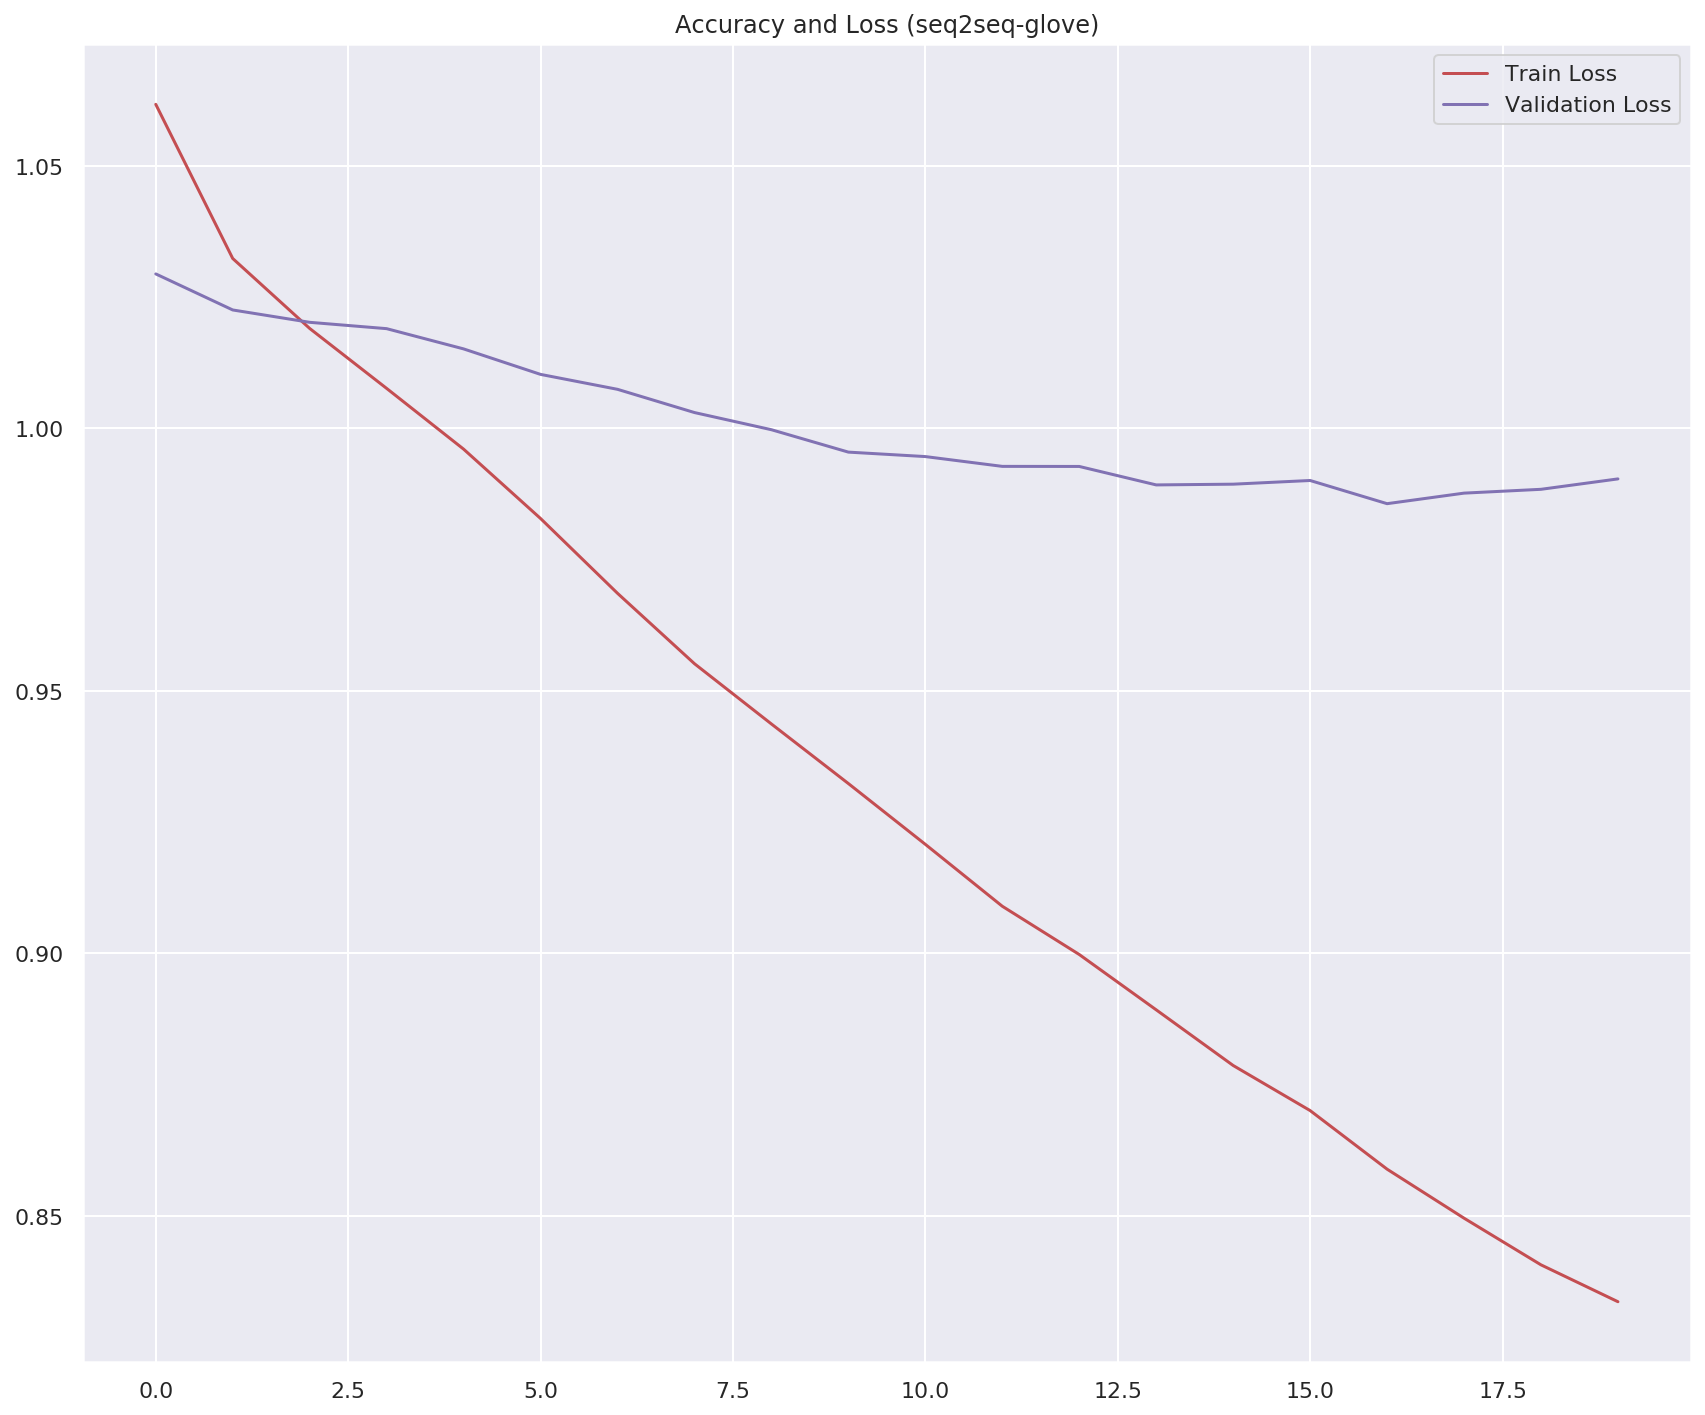

In [54]:
# seq2seq_glove_train
LOAD_EXISTING_WEIGHTS = False


def main():
    np.random.seed(42)
    very_large_data_dir_path = './very_large_data'
    report_dir_path = 'reports'
    model_dir_path = 'models'
    
    if not os.path.exists(report_dir_path):
      os.mkdir(report_dir_path)
    if not os.path.exists(model_dir_path):
      os.mkdir(model_dir_path)

    print('loading csv file ...')
    df = pd.read_csv("fake_or_real_news.csv")
    print('extract configuration from input texts ...')
    Y = df.title
    X = df['text']
    config = fit_text(X, Y)
    print('configuration extracted from input texts ...')
    summarizer = Seq2SeqGloVeSummarizer(config)
    summarizer.load_glove(very_large_data_dir_path)
    if LOAD_EXISTING_WEIGHTS:
        summarizer.load_weights(weight_file_path=Seq2SeqGloVeSummarizer.get_weight_file_path(model_dir_path=model_dir_path))
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
    print('training size: ', len(Xtrain))
    print('testing size: ', len(Xtest))
    print('start fitting ...')
    history = summarizer.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=20, batch_size=16)
    history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizer.model_name + '-history.png'
    if LOAD_EXISTING_WEIGHTS:
        history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizer.model_name + '-history-v' + str(summarizer.version) + '.png'
    plot_and_save_history(history, summarizer.model_name, history_plot_file_path, metrics={'loss', 'accuracy'})

if __name__ == '__main__':
    main()

In [20]:
def main():
    np.random.seed(42)
    very_large_data_dir_path = './very_large_data'
    model_dir_path = './models'
    print('loading csv file ...')
    df = pd.read_csv("fake_or_real_news.csv")
    X = df['text']
    Y = df.title
    print('loading config files ...')
    config = np.load(Seq2SeqGloVeSummarizer.get_config_file_path(model_dir_path=model_dir_path)).item()
    summarizer = Seq2SeqGloVeSummarizer(config)
    print('loading pretrained embedding ... ')
    summarizer.load_glove(very_large_data_dir_path)
    print('loading trained weights ...')
    summarizer.load_weights(weight_file_path=Seq2SeqGloVeSummarizer.get_weight_file_path(model_dir_path=model_dir_path))
    print("number of samples to generate?")
    samples = int(input())
    print('start predicting ...')
    for n, i in enumerate(np.random.permutation(np.arange(len(X)))[0:samples]):
        x = X[i]
        actual_headline = Y[i]
        headline = summarizer.summarize(x)
        print('sample: ', n+1)
        print('News: ',x)
        print('Generated Headline: ', headline)
        print('Original Headline: ', actual_headline)
        print()
if __name__ == '__main__':
    main()

loading csv file ...
loading config files ...
loading pretrained embedding ... 
loading trained weights ...
number of samples to generate?
3
start predicting ...
sample:  0
News:  Will Trump pull a Brexit times ten? What would it take, beyond WikiLeaks, to bring the Clinton (cash) machine down? Will Hillary win and then declare WWIII against her Russia/Iran/Syria “axis of evil”? Will the Middle East totally explode? Will the pivot to Asia totally implode? Will China be ruling the world by 2025?
Amidst so many frenetic fragments of geopolitical reality precariously shored against our ruins, the temptation is irresistible to hark back to the late, great, deconstructionist master Jean Baudrillard. During the post-mod 1980s it was hip to be Baudrillardian to the core; his America, originally published in France in 1986, should still be read today as the definitive metaphysical/geological/cultural Instagram of Exceptionalistan.
By the late 1990s, at the end of the millennium, two years befo

loading csv file ...
extract configuration from input texts ...
configuration extracted from input texts ...
demo size:  5068
testing size:  1267
start fitting ...
(5068,)
(1267,)
(5068, 500, 100)
(1267, 500, 100)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 316 steps, validate for 79 steps
Epoch 1/20
316/316 [==============================] - 14s 43ms/step - loss: 1.0612 - accuracy: 0.0224 - val_loss: 1.0312 - val_accuracy: 0.0224
Epoch 2/20
316/316 [==============================] - 11s 35ms/step - loss: 1.0346 - accuracy: 0.0230 - val_loss: 1.0259 - val_accuracy: 0.0228
Epoch 3/20
316/316 [==============================] - 11s 35ms/step - loss: 1.0223 - accuracy: 0.0231 - val_loss: 1.0261 - val_accuracy: 0.0228
Epoch 4/20
316/316 [==============================] - 11s 35ms/step - loss: 1.0133 - accuracy: 0.0231 - val_loss: 1.0278 - val_accuracy: 0.0228
Epoch 5/20
316/316 [==============================] - 11s 36ms/step - loss: 1.0068 - accuracy: 0.0232 - val_loss: 1.0

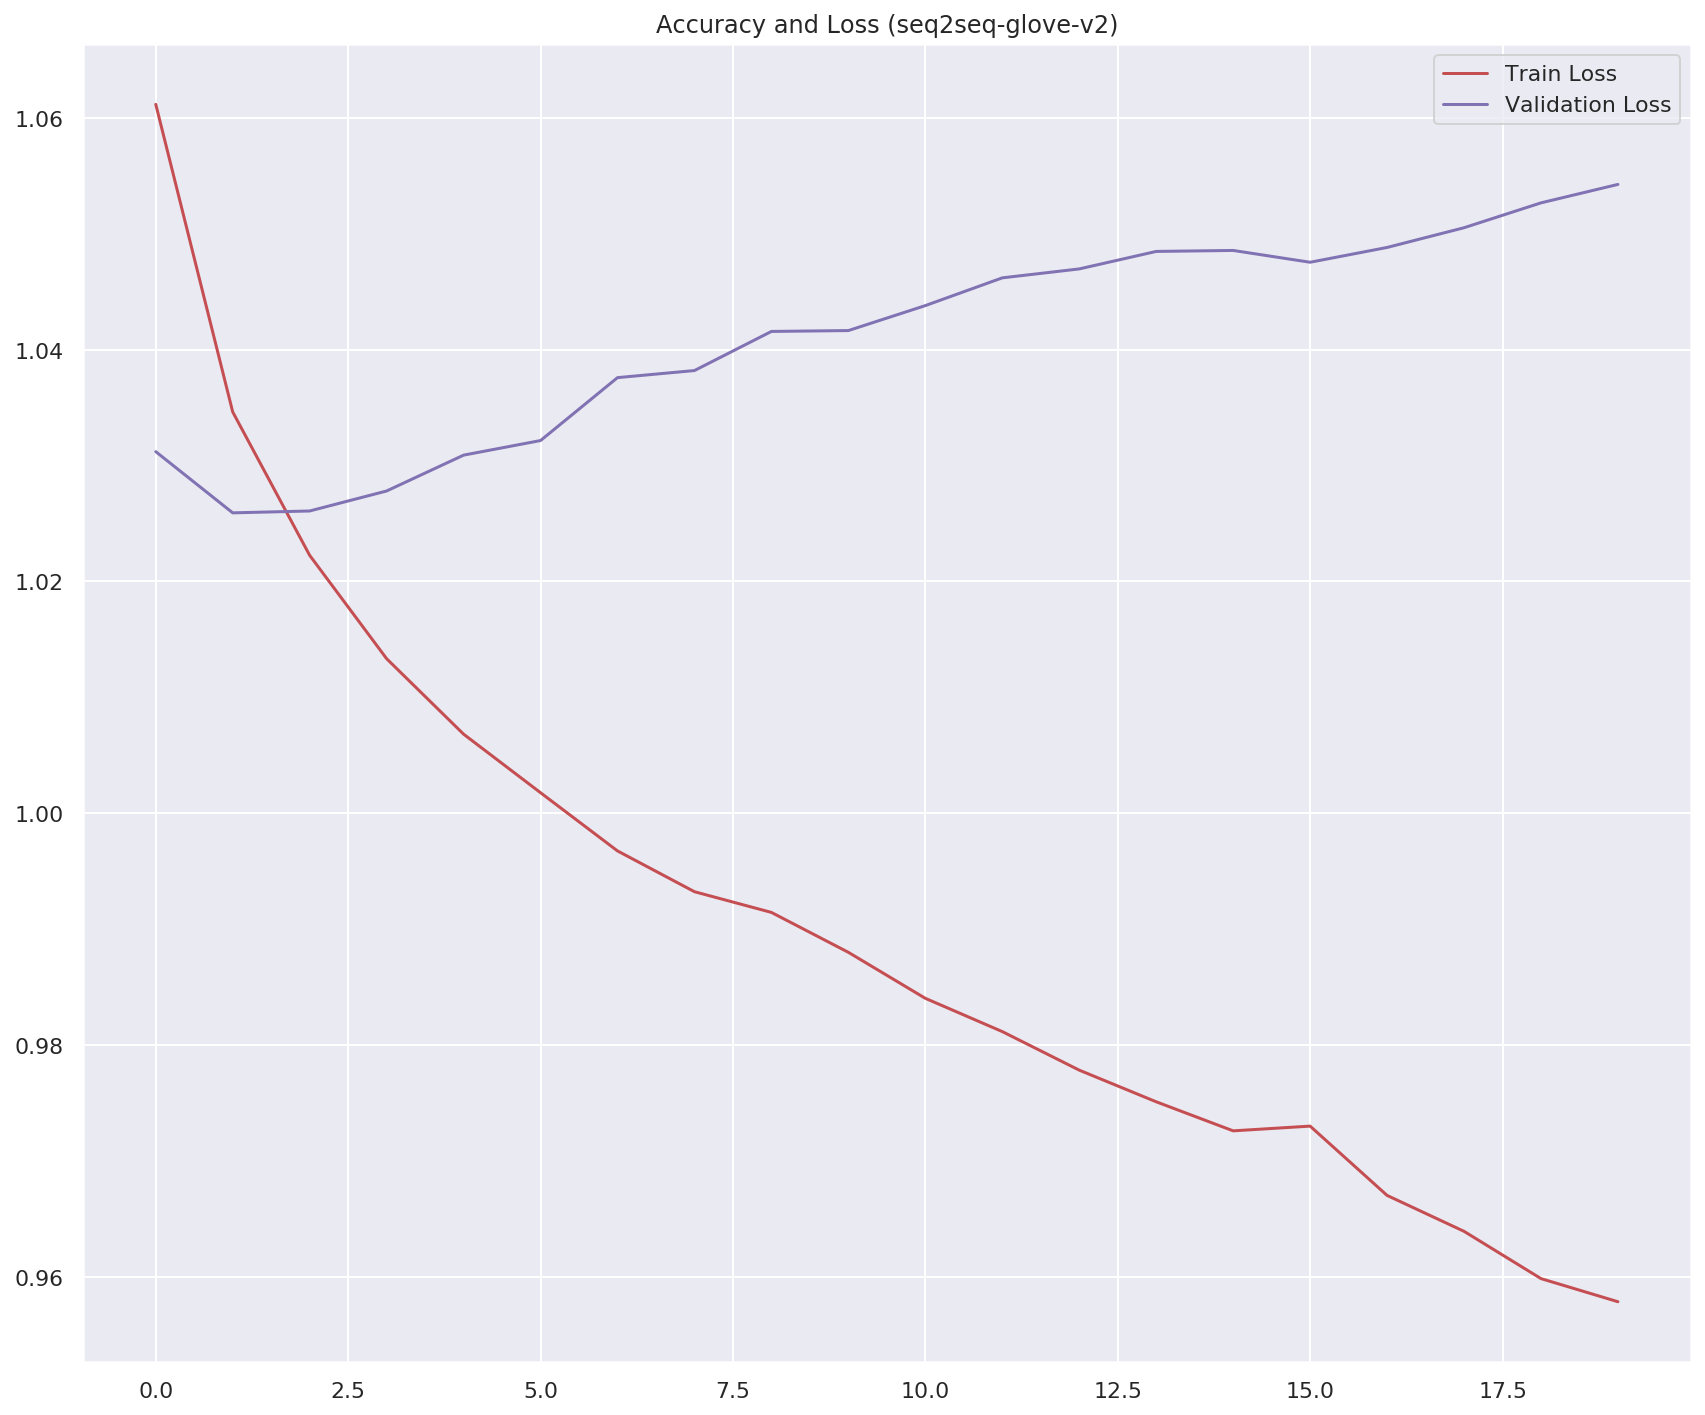

In [24]:
# seq2seq glove 2
LOAD_EXISTING_WEIGHTS = False


def main():
    np.random.seed(42)
    very_large_data_dir_path = './very_large_data'
    report_dir_path = 'reports'
    model_dir_path = 'models'

    if not os.path.exists(report_dir_path):
      os.mkdir(report_dir_path)
    if not os.path.exists(model_dir_path):
      os.mkdir(model_dir_path)

    print('loading csv file ...')
    df = pd.read_csv("fake_or_real_news.csv")

    print('extract configuration from input texts ...')
    Y = df.title
    X = df['text']
    config = fit_text(X, Y)

    print('configuration extracted from input texts ...')

    summarizer = Seq2SeqGloVeSummarizerV2(config)
    summarizer.load_glove(very_large_data_dir_path)

    if LOAD_EXISTING_WEIGHTS:
        summarizer.load_weights(weight_file_path=Seq2SeqGloVeSummarizerV2.get_weight_file_path(model_dir_path=model_dir_path))

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

    print('demo size: ', len(Xtrain))
    print('testing size: ', len(Xtest))

    print('start fitting ...')
    history = summarizer.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=20, batch_size=16)

    history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-history.png'
    if LOAD_EXISTING_WEIGHTS:
        history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-history-v' + str(summarizer.version) + '.png'
    plot_and_save_history(history, summarizer.model_name, history_plot_file_path, metrics={'loss', 'accuracy'})


if __name__ == '__main__':
    main()

In [26]:
def main():
    np.random.seed(42)
    very_large_data_dir_path = './very_large_data'
    model_dir_path = './models'

    print('loading csv file ...')
    df = pd.read_csv("fake_or_real_news.csv")
    X = df['text']
    Y = df.title
    print('loading config files ...')
    config = np.load(Seq2SeqGloVeSummarizerV2.get_config_file_path(model_dir_path=model_dir_path)).item()

    summarizer = Seq2SeqGloVeSummarizerV2(config)
    print('loading pretrained embedding ... ')
    summarizer.load_glove(very_large_data_dir_path)
    print('loading trained weights ...')
    summarizer.load_weights(weight_file_path=Seq2SeqGloVeSummarizerV2.get_weight_file_path(model_dir_path=model_dir_path))
    print("number of samples to generate?")
    samples = int(input())
    print('start predicting ...')
    for n, i in enumerate(np.random.permutation(np.arange(len(X)))[0:samples]):
        x = X[i]
        actual_headline = Y[i]
        headline = summarizer.summarize(x)
        print('sample: ', n+1)
        print('Generated Headline: ', headline)
        print('Original Headline: ', actual_headline)
        print('News: ',x)
        print()

if __name__ == '__main__':
    main()

loading csv file ...
loading config files ...
loading pretrained embedding ... 
loading trained weights ...
number of samples to generate?
1
start predicting ...
sample:  0
Generated Headline:  the  information the  the
Original Headline:  American Dream, Revisited
News:  Will Trump pull a Brexit times ten? What would it take, beyond WikiLeaks, to bring the Clinton (cash) machine down? Will Hillary win and then declare WWIII against her Russia/Iran/Syria “axis of evil”? Will the Middle East totally explode? Will the pivot to Asia totally implode? Will China be ruling the world by 2025?
Amidst so many frenetic fragments of geopolitical reality precariously shored against our ruins, the temptation is irresistible to hark back to the late, great, deconstructionist master Jean Baudrillard. During the post-mod 1980s it was hip to be Baudrillardian to the core; his America, originally published in France in 1986, should still be read today as the definitive metaphysical/geological/cultural I